In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle

In [2]:
data_path = os.path.join(os.getcwd(),"cerebellum_data")

In [3]:
def process_data():
    cached = {}
    output = []
    for s in ["counts", "genes", "metadata"]:
        #check if we have already processed the dataset
        filename = os.path.join(data_path,"cerebellum_%s.pickle" % s)
        cached = os.path.isfile(filename)
        if cached:
            output.append(pd.read_pickle(filename))
        else:
            #if not processed, read from csv and save pickled file
            csv_file = os.path.join(data_path, "cerebellum_%s.csv" % s)
            df = pd.read_csv(csv_file,index_col=0)
            if s in ['counts','genes']:
                df = df.transpose()
            df.to_pickle(filename)
            output.append(df)
    return output

In [4]:
%%time

counts, genes, metadata = process_data()

CPU times: user 611 ms, sys: 2.61 s, total: 3.22 s
Wall time: 8.24 s


In [5]:
#in case we need to correct for excel conversions

#lookup = dict(counts)
#for g in genes.loc['gene'].tolist():
#    if g not in lookup:
#        print(g)

In [6]:
considered_types = ['Granule', 'Purkinje', 'Astrocytes']
#filter by cell type
c_subset = counts.loc[metadata['liger_ident_coarse'].isin(considered_types)]
#filter genes
c_subset = c_subset.filter(genes.loc['gene'].tolist())
#normalize matrix of counts
#(note: these proportions are conditioned on genes being in frequent set)
c_subset = c_subset.div(c_subset.sum(axis=1), axis=0)

In [7]:
def generate_doublets(rows = 10000):
    num_rows = rows
    doublets_file = os.path.join(data_path,"doublets_%s.pickle" % num_rows)
    origins_file = os.path.join(data_path,"origins_%s.pickle" % num_rows)
    #check if cached
    if os.path.isfile(doublets_file) and os.path.isfile(origins_file):
        return pd.read_pickle(doublets_file), pd.read_pickle(origins_file)
    
    row_list = []
    gen_list = []
    for i in range(num_rows):
        sample = c_subset.sample(n = 2, replace = True)
        
        #append new row to dataframe
        new_row = sample.sum()
        row_list.append(new_row)
        
        #keep track of the ground truth cells
        gen_cells = sample.index.tolist()
        gen_list.append(gen_cells)
        
    mixtures = pd.DataFrame(row_list)
    origins = pd.DataFrame(gen_list)
    
    #normalize
    mixtures = mixtures.div(mixtures.sum(axis=1), axis=0)
    mixtures.to_pickle(doublets_file)
    origins.to_pickle(origins_file)
    return mixtures, origins

In [8]:
%time doublets, origins = generate_doublets(360)

print(doublets)
print(origins)

CPU times: user 3.42 ms, sys: 4.66 ms, total: 8.08 ms
Wall time: 43.4 ms
        Grid2     Pcsk6     Gria1     Prkg1     Sntg1  Cntnap5a      Gad1  \
0    0.002292  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.010321  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.039284  0.001216  0.000640  0.008829  0.000064  0.000320  0.000320   
3    0.035334  0.000601  0.000343  0.004249  0.000000  0.000086  0.000129   
4    0.067627  0.000674  0.000778  0.010916  0.000233  0.000428  0.000078   
..        ...       ...       ...       ...       ...       ...       ...   
355  0.043343  0.000373  0.000187  0.008861  0.000806  0.000249  0.000124   
356  0.045186  0.000000  0.004121  0.000948  0.000000  0.000000  0.000000   
357  0.071904  0.000508  0.000610  0.010336  0.000508  0.000169  0.000203   
358  0.068352  0.000831  0.000489  0.010726  0.000147  0.000635  0.000049   
359  0.052361  0.000489  0.000489  0.004581  0.000180  0.000206  0.000180   

  

In [9]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [10]:
%time lda = LDA(n_components=3, max_iter=100, random_state=0)
lda.fit(doublets)
print(lda.transform(doublets))

CPU times: user 11 µs, sys: 15 µs, total: 26 µs
Wall time: 31.7 µs
[[0.1745784  0.17457841 0.65084319]
 [0.17622564 0.17622564 0.64754872]
 [0.17392182 0.17392182 0.65215635]
 ...
 [0.17503798 0.17503798 0.64992403]
 [0.17510081 0.17510081 0.64979839]
 [0.17310268 0.17310268 0.65379464]]


In [12]:
lda_fits = {}
sim_doublets = {}
sim_origins = {}
sizes = [100000]

for size in sizes:
    doublets, origins = generate_doublets(size)
    sim_doublets[size] = doublets
    sim_origins[size] = origins
    ldafit_file = os.path.join(data_path,"ldafit_%s.pickle.npy" % size)
    if os.path.isfile(ldafit_file):
        print("using pickled file for size", size)
        lda_fits[size] = np.load(file = ldafit_file, allow_pickle=True)
    else:
        %time lda.fit(doublets)
        %time lda_fits[size] = lda.transform(doublets)
        print(lda.transform(doublets))
        np.save(file=os.path.join(data_path,"ldafit_%s.pickle" % size), arr=lda_fits[size])

using pickled file for size 100000


In [13]:
celldict = dict(metadata.loc[metadata['liger_ident_coarse'].isin(considered_types)]['liger_ident_coarse'])
decomp = []
typeindex = {e: i for i, e in enumerate(considered_types)}
indexer = sim_origins[100000].applymap(
    lambda cell: typeindex[celldict[cell]])
%time indicators = pd.get_dummies(indexer[0]) | pd.get_dummies(indexer[1])

CPU times: user 14 ms, sys: 2.3 ms, total: 16.3 ms
Wall time: 397 ms


In [17]:
thresholds = np.linspace(0.15,0.45,num=60)
accs = []
a = indicators.values

In [19]:
for t in thresholds:
    b = np.apply_along_axis(lambda row: [1 if k > t else 0 for k in row], 1, lda_fits[100000])
    
    bad = 0        
    
    for i, e in enumerate(zip(a, b)):
        x, y = e
        if any(x != y):
            bad += 1
    acc = 1-bad/100000
    accs.append(acc)

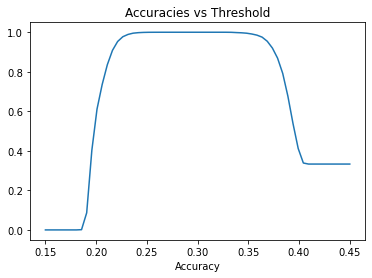

In [20]:
plt.plot(thresholds,accs)
plt.title("Accuracies vs Threshold")
plt.xlabel("Threshold")
plt.xlabel("Accuracy")
plt.show()